In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv2D, MaxPool2D

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import cv2
import zipfile
import shutil
import os
import glob

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# 1. GTSRB project -1
- https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html
- https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
- https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

## colab에서 data 준비

In [2]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## 압축 풀기

In [3]:
with zipfile.ZipFile("data/GTSRB_Final_Training_Images.zip") as target_file:
    target_file.extractall("data/GTSRB_Final_Training_Images")
    print("success!")

success!


## (1) Data Definition

In [31]:
DATA_ROOT_DIR = "data\\GTSRB_Final_Training_Images\\GTSRB\\Final_Training\\Images"

label_name_list = os.listdir(DATA_ROOT_DIR)

In [32]:
image_list = []
label_list = []

start_time = datetime.now()

for label_name in label_name_list:
    file_path = os.path.join(DATA_ROOT_DIR, label_name)
    img_file_list = glob.glob(file_path + "/*.ppm")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(32, 32))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(int(label_name))

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)


걸린시간 :  0:00:08.816135


In [33]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_list), np.array(label_list), test_size=0.2)

In [34]:
print(X_train.shape, X_test.shape)

(31367, 32, 32, 3) (7842, 32, 32, 3)


In [35]:
print(y_train.shape, y_test.shape)

(31367,) (7842,)


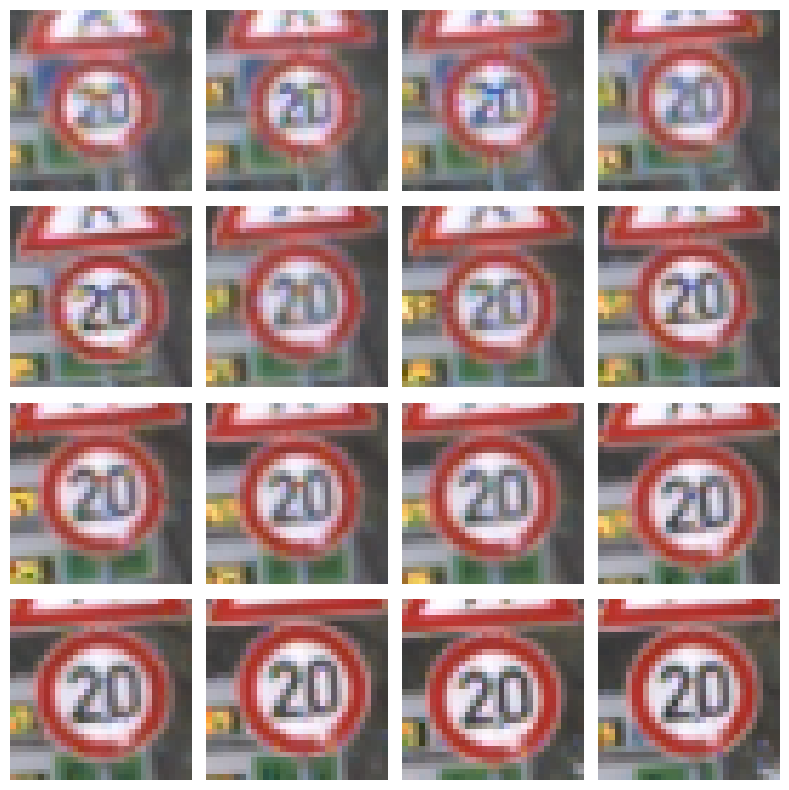

In [30]:
##### 대략 16개의 임의의 이미지 출력

rnd_idx = np.random.randint(0, len(image_list),16)

plt.figure(figsize=(8,8))

import random

for idx in range(len(rnd_idx)):
    plt.subplot(4, 4, idx+1)
    plt.imshow(image_list[idx])
    plt.axis('off')
    
plt.tight_layout()

In [ ]:
"""
sequential : CCPCCPFDD
callback : EarlyStopping
optimizer : Adam
epochs : 30
validation : yes
goal : 99%
시간측정
오답노트
그래프로 과적합 여부 확인
"""


In [9]:
X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

n_classes = len(os.listdir(DATA_ROOT_DIR))

model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
# model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 입력층
model.add(Flatten())

# 은닉층
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# 출력층
model.add(Dense(n_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
tf_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

start_time = datetime.now()

result = model.fit(X_train, y_train, epochs=30, validation_split=.2, batch_size=1000,  callbacks=[tf_stop])

end_time = datetime.now()

model.evaluate(X_test, y_test)

print("걸린 시간:", end_time - start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [10]:
# 강사님 compile 아래

save_file_name = 'data/GTSRB_Native.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

start_time = datetime.now()

hist = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data = (X_test, y_test), callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time =>', end_time - start_time)

Epoch 1/30
980/981 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9549
Epoch 1: val_loss improved from inf to 0.04065, saving model to data\GTSRB_Native.h5
981/981 [==============================] - 51s 52ms/step - loss: 0.1556 - accuracy: 0.9550 - val_loss: 0.0406 - val_accuracy: 0.9913
Epoch 2/30
980/981 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9822
Epoch 2: val_loss did not improve from 0.04065
981/981 [==============================] - 51s 52ms/step - loss: 0.0614 - accuracy: 0.9822 - val_loss: 0.0434 - val_accuracy: 0.9894
Epoch 3/30
980/981 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9888
Epoch 3: val_loss improved from 0.04065 to 0.02480, saving model to data\GTSRB_Native.h5
981/981 [==============================] - 51s 52ms/step - loss: 0.0387 - accuracy: 0.9888 - val_loss: 0.0248 - val_accuracy: 0.9944
Epoch 4/30
980/981 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9

In [11]:
model.evaluate(X_test, y_test)

246/246 [==============================] - 2s 8ms/step - loss: 0.0345 - accuracy: 0.9930


[0.03451469540596008, 0.9929865002632141]

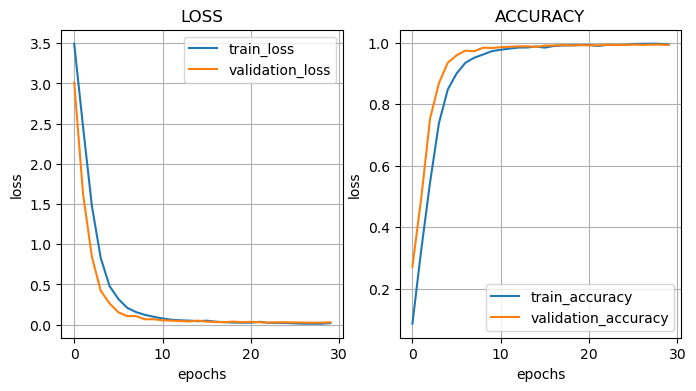

In [12]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [13]:
# 오답 노트
ret_val = model.predict(X_test.reshape(-1, 32, 32, 3))
print(ret_val.shape)
print(ret_val)

# 정답을 알아보기 쉽게 인덱스 값으로 argmax
pred_val = np.argmax(ret_val, axis=1)
pred_comp_val = np.equal(pred_val, y_test)

index_label_pred_list = [[idx, y_test[idx], pred_val[idx]] for idx, result in enumerate(pred_comp_val) if result==False]

# 이미지의 위치, 이미지의 정답, 예측값
index_label_pred_list[0]

print(len(index_label_pred_list))

print(index_label_pred_list)

246/246 [==============================] - 2s 9ms/step
(7842, 43)
[[2.79312022e-08 5.70822915e-04 9.99310613e-01 ... 1.90068783e-09
  4.74642853e-16 5.28421369e-14]
 [3.06695525e-38 5.66079993e-32 3.02608685e-28 ... 1.63503147e-28
  0.00000000e+00 4.83682884e-38]
 [4.27249295e-16 1.00000000e+00 1.03628294e-16 ... 6.41938523e-21
  2.22983802e-31 1.46868375e-27]
 ...
 [5.41618582e-23 1.73821989e-20 4.12203290e-17 ... 2.53873273e-27
  4.47158418e-28 2.57989718e-31]
 [5.51612631e-15 2.41434008e-11 4.24119377e-12 ... 2.43880247e-13
  4.64047033e-17 1.36942904e-19]
 [5.80830482e-15 1.11457393e-20 3.48070422e-22 ... 2.62812777e-20
  1.58110590e-18 9.23210405e-22]]
55
[[33, 26, 35], [63, 11, 13], [244, 4, 1], [292, 4, 1], [357, 18, 25], [714, 4, 7], [716, 1, 2], [772, 33, 35], [821, 29, 2], [991, 5, 1], [999, 9, 3], [1011, 4, 8], [1143, 2, 7], [1244, 20, 25], [1517, 9, 3], [1559, 1, 5], [1900, 5, 4], [1931, 35, 37], [2161, 2, 1], [2248, 36, 35], [2435, 15, 13], [2612, 4, 1], [2739, 2, 5], [292

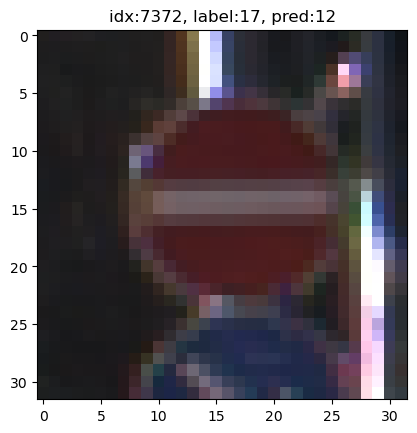

In [14]:
false_data_index = np.random.randint(len(index_label_pred_list))
false_data_index

panel_index = index_label_pred_list[false_data_index][0]
label = index_label_pred_list[false_data_index][1]
pred = index_label_pred_list[false_data_index][2]

img = X_test[panel_index]

title = "idx:{}, label:{}, pred:{}".format(str(panel_index), str(label), str(pred))

plt.title(title)
plt.imshow(img, cmap='gray')
plt.show()

# 2. GTSRB project-2

- train과 test폴더 생성 후 데이터 준비

        GTSRB_Final_Training_Images
            I GTSRB
                I Final_Training
                    I Images
                        I 00000
                        I 00001
                        ...
                        I 00042
                        
        ------------------------------------------------------------------
        GTSRB
            I Train
                I 00000
                ....
                I 00042
            I Test
                I 00000
                ...
                I 00042


In [2]:
with zipfile.ZipFile("data/GTSRB_Final_Training_Images.zip") as target_file:
    target_file.extractall("data/GTSRB_Final_Training_Images")
    print("success!")

success!


In [3]:
DATA_ROOT_DIR = "data\\GTSRB_Final_Training_Images\\GTSRB\\Final_Training\\Images"

label_name_list = os.listdir(DATA_ROOT_DIR)

In [4]:
##### GTSRB 폴더 만들기

if os.path.exists("data/GTSRB"):
    shutil.rmtree("data/GTSRB")
    print("data/GTSRB is deleted!")

if not os.path.exists("data/GTSRB"):
    os.mkdir("data/GTSRB")
    print("GTSRB directory is created!")
    
## colab일경우
#os.path.exists("/content/GTSRB")

data/GTSRB is deleted!
GTSRB directory is created!


In [5]:
##### 전체 데이터를 GTSRB/train으로 복사하기

src_root_dir = "data\\GTSRB_Final_Training_Images\\GTSRB\\Final_Training\\Images"
dst_root_dir = "data/GTSRB/train"

if os.path.exists(dst_root_dir):
    shutil.rmtree(dst_root_dir)
    print(dst_root_dir, "is deleted!")

start_time = datetime.now()    
    
shutil.copytree(src_root_dir, dst_root_dir)

end_time = datetime.now()

print(f'걸린시간 :{end_time - start_time}')

걸린시간 :0:00:56.730766


In [6]:
##### test 폴더 GTSRB/test안에 만들기

if not os.path.exists("data/GTSRB/test"):
    os.mkdir("data/GTSRB/test")
    print("GTSRB/test directory is created!")
    
    count = 0
    for label_name in label_name_list:
        os.mkdir("data/GTSRB/test/" + label_name.strip())
        print("data/GTSRB/test/" + label_name.strip() + "is created")
        count = count + 1
        
    print("총 횟수 :", count)

GTSRB/test directory is created!
data/GTSRB/test/00000is created
data/GTSRB/test/00001is created
data/GTSRB/test/00002is created
data/GTSRB/test/00003is created
data/GTSRB/test/00004is created
data/GTSRB/test/00005is created
data/GTSRB/test/00006is created
data/GTSRB/test/00007is created
data/GTSRB/test/00008is created
data/GTSRB/test/00009is created
data/GTSRB/test/00010is created
data/GTSRB/test/00011is created
data/GTSRB/test/00012is created
data/GTSRB/test/00013is created
data/GTSRB/test/00014is created
data/GTSRB/test/00015is created
data/GTSRB/test/00016is created
data/GTSRB/test/00017is created
data/GTSRB/test/00018is created
data/GTSRB/test/00019is created
data/GTSRB/test/00020is created
data/GTSRB/test/00021is created
data/GTSRB/test/00022is created
data/GTSRB/test/00023is created
data/GTSRB/test/00024is created
data/GTSRB/test/00025is created
data/GTSRB/test/00026is created
data/GTSRB/test/00027is created
data/GTSRB/test/00028is created
data/GTSRB/test/00029is created
data/GT

In [7]:
##### train 데이터에서 비율에 따라 test 데이터를 분리함


# 분리 비율 ( 8 : 2)
ratio = 0.2

src_root_dir = "data/GTSRB/train/"
dst_root_dir = "data/GTSRB/test/"

for label_name in label_name_list:
    train_image_file_list = glob.glob(src_root_dir + label_name + "/*")
    print("===================================")
    print("total [%s] image file nums => [%s]"%(label_name, len(train_image_file_list)))
          

    split_num = int(ratio * len(train_image_file_list))
    print("분리할 갯수 :", split_num)
    
    test_image_file_list = train_image_file_list[0 : split_num]
    
    move_nums = 0
    for image_file in test_image_file_list:
        shutil.move(image_file, dst_root_dir + label_name)
        move_nums = move_nums + 1
    print("total move nums -> ", move_nums)
    print("===================================")

total [00000] image file nums => [211]
분리할 갯수 : 42
total move nums ->  42
total [00001] image file nums => [2221]
분리할 갯수 : 444
total move nums ->  444
total [00002] image file nums => [2251]
분리할 갯수 : 450
total move nums ->  450
total [00003] image file nums => [1411]
분리할 갯수 : 282
total move nums ->  282
total [00004] image file nums => [1981]
분리할 갯수 : 396
total move nums ->  396
total [00005] image file nums => [1861]
분리할 갯수 : 372
total move nums ->  372
total [00006] image file nums => [421]
분리할 갯수 : 84
total move nums ->  84
total [00007] image file nums => [1441]
분리할 갯수 : 288
total move nums ->  288
total [00008] image file nums => [1411]
분리할 갯수 : 282
total move nums ->  282
total [00009] image file nums => [1471]
분리할 갯수 : 294
total move nums ->  294
total [00010] image file nums => [2011]
분리할 갯수 : 402
total move nums ->  402
total [00011] image file nums => [1321]
분리할 갯수 : 264
total move nums ->  264
total [00012] image file nums => [2101]
분리할 갯수 : 420
total move nums ->  420
total

In [8]:
DATA_ROOT_DIR = "data\\GTSRB\\train"

label_name_list = os.listdir(DATA_ROOT_DIR)

In [9]:
label_name_list

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042']

In [10]:
image_list = []
label_list = []

start_time = datetime.now()

for label_name in label_name_list:
    file_path = os.path.join(DATA_ROOT_DIR, label_name) # 2개 이상의 경로를 결합한다 # os.path.join
    img_file_list = glob.glob(file_path + "/*.ppm")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(32, 32))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(int(label_name))

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)


걸린시간 :  0:00:06.376535


In [11]:
file_path = os.path.join(DATA_ROOT_DIR, label_name)
file_path

'data\\GTSRB\\train\\00042'

In [12]:
image_list

[array([[[ 73,  64,  43],
         [121,  79,  61],
         [179, 108, 118],
         ...,
         [182, 137, 129],
         [148, 145, 153],
         [113, 127, 154]],
 
        [[ 70,  67,  44],
         [126,  87,  68],
         [184, 112, 128],
         ...,
         [161,  89,  46],
         [187, 153, 146],
         [133, 119, 172]],
 
        [[ 89,  81,  61],
         [135,  92,  71],
         [166,  90,  80],
         ...,
         [155,  75,  34],
         [142,  94,  86],
         [137, 108, 152]],
 
        ...,
 
        [[255, 205, 183],
         [229, 231, 199],
         [113, 122, 115],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 231, 199],
         [248, 250, 222],
         [210, 229, 219],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 254, 222],
         [254, 255, 253],
         [244, 255, 254],
         ...,
         [255, 255, 255],
  

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_list), np.array(label_list), test_size=0.2)

In [14]:
print(X_train.shape, X_test.shape)

(25093, 32, 32, 3) (6274, 32, 32, 3)


In [15]:
print(y_train.shape, y_test.shape)

(25093,) (6274,)


In [16]:
#강사님
X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

n_classes = len(os.listdir(DATA_ROOT_DIR))

model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
# model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))
model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 입력층
model.add(Flatten())

# 은닉층
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# 출력층
model.add(Dense(n_classes, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [17]:
# 강사님 compile 아래
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

save_file_name = 'data/GTSRB_Native.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

start_time = datetime.now()

hist = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data = (X_test, y_test), callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time =>', end_time - start_time)

Epoch 1/30
784/785 [============================>.] - ETA: 0s - loss: 1.3586 - accuracy: 0.6050
Epoch 1: val_loss improved from inf to 0.14069, saving model to data\GTSRB_Native.h5
785/785 [==============================] - 50s 56ms/step - loss: 1.3583 - accuracy: 0.6051 - val_loss: 0.1407 - val_accuracy: 0.9589
Epoch 2/30
784/785 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9544
Epoch 2: val_loss improved from 0.14069 to 0.05602, saving model to data\GTSRB_Native.h5
785/785 [==============================] - 44s 56ms/step - loss: 0.1543 - accuracy: 0.9543 - val_loss: 0.0560 - val_accuracy: 0.9818
Epoch 3/30
784/785 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9764
Epoch 3: val_loss improved from 0.05602 to 0.02491, saving model to data\GTSRB_Native.h5
785/785 [==============================] - 44s 56ms/step - loss: 0.0821 - accuracy: 0.9764 - val_loss: 0.0249 - val_accuracy: 0.9935
Epoch 4/30
784/785 [============================>.

In [19]:
model.evaluate(X_test, y_test)

197/197 [==============================] - 2s 8ms/step - loss: 0.0250 - accuracy: 0.9944


[0.024974221363663673, 0.9944214224815369]

# 3. Surface Crack Detection

- https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
- 아래 코드들은 모두 colab에서 실행
- 227 * 227의 컬러 이미지 데이터
- crack이 없는 Negative 2만개, crack이 발생한 positive 2만개
- train, test 폴더 생성하고 8:2 비율로 저장한 후 학습 데이터 생성
- 99% 이상의 정확도와 오버피팅이 거의 없는 CNN 모델 작성

In [ ]:
from google.colab import drive

drive.mount("content/gdrive/")

In [ ]:
import os

data_path = "/content/gdrive/My Drive/"

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "surface_crack")

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")

In [ ]:
import zipfile

if os.path.exists(DATA_ROOT_DIR):
  shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "archive1.zip")) as target_file:
  target_file.extractall(DATA_ROOT_DIR)

In [ ]:
label_name_list = os.listdir(DATA_ROOT_DIR)

for label_name in label_name_list:
  print(len(os.listdir(os.path.join(DATA_ROOT_DIR, label_name))))

In [ ]:
# train이라는 폴더가 생성되며 Negative, Positive 폴더가 하위폴더로 복사되었다.
shutil.copytree(DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR)

In [ ]:
if not os.path.exists(TEST_DATA_ROOT_DIR):
  os.mkdir(TEST_DATA_ROOT_DIR)

In [ ]:
# test 폴더에 Positive폴더와 Negative 폴더를 만들어라.

if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, "Positive")):
  os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, "Positive"))

if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, "Negative")):
  os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, "Negative"))

In [ ]:
import glob
import random

MOVE_RATIO = 0.2

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    # 잘 지정되었는지 확인용 print
    train_data_file_list = os.listdir(src)
    print(len(train_data_file_list))

    # 파일 순서 섞는용
    random.shuffle(train_data_file_list)

    # 몇번째까지 분할하면 되는지 확인용
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print(split_num)

    # 0부터 split_num까지 test로 옮기자
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                os.path.join(dst, test_data_file))
    move_nums = move_nums +1

    print(move_nums)